In [1]:
!pip uninstall -y kaggle

Found existing installation: kaggle 1.5.12
Uninstalling kaggle-1.5.12:
  Successfully uninstalled kaggle-1.5.12


In [2]:
!pip install --upgrade pip
!pip install kaggle==1.5.6
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle competitions download journey-springfield
import zipfile
import os
zip_file = '/content/journey-springfield.zip'
z = zipfile.ZipFile(zip_file, 'r')
z.extractall()

     |████████████████████████████████| 1.7 MB 5.3 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
     |████████████████████████████████| 58 kB 2.9 MB/s             
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.6-py3-none-any.whl size=72857 sha256=fd481171c63329ff3a9c802c9270bca0e2f55748f89b3c80d08dd41cb55194ca
  Stored in directory: /root/.cache/pip/wheels/aa/e7/e7/eb3c3d514c33294d77ddd5a856bdd58dc9c1fabbed59a02a2b
Successfully built kaggle
 98% 513M/521M [00:03<00:00, 154MB/s]
100% 521M/521M [00:03<00:00, 143MB/s]


In [3]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CPU ')
else:
    print('GPU')

CPU 


In [4]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [5]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [7]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            
            #
            #a           t!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
            # u        n
            #   g    e 
            #      m                        
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [8]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [9]:
TRAIN_DIR = Path('/content/train/simpsons_dataset')
TEST_DIR = Path('/content/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [10]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [11]:
val_dataset = SimpsonsDataset(val_files, mode='val')

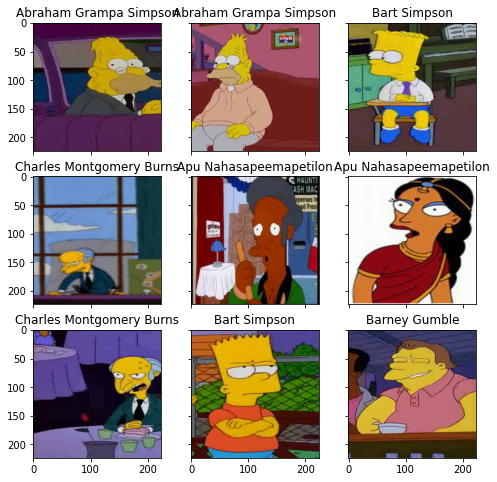

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [ ]:
def fit_one_epoch(model, loader, criterion, optimizer):
  all_data = 0 # processed data per epoch
  loss_running = 0.0 
  correct_sample = 0
  for inputs, labels in loader:
    inputs = inputs.to(DEVICE)
    labels = labels.to(DEVICE)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    preds = torch.argmax(outputs, 1)
    loss_running += loss.item()*inputs.size(0)
    correct_sample += torch.sum(preds == labels.data)
    all_data += inputs.size(0)
  train_loss = loss_running / all_data
  train_acc = correct_sample.cpu().numpy() / all_data
  return train_loss, train_acc

In [ ]:
def eval_one_epoch(model, loader, criterion):
  model.eval()
  all_data = 0 # processed data per epoch
  loss_running = 0.0 
  correct_sample = 0
  for inputs, labels in loader:
      inputs = inputs.to(DEVICE)
      labels = labels.to(DEVICE)
      with torch.set_grad_enabled(False):
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        preds = torch.argmax(outputs, 1)
      correct_sample += torch.sum(preds == label.data)
      loss_running += loss.item()*inputs.size(0)
      all_data += inputs.size(0)
  val_acc = correct_sample.double() / all_data
  val_loss = loss_running / all_data
  return val_loss, val_acc

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer): ###!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0 #!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_dataset, val_dataset, model, opt, epochs, batch_size):#!!!!!!!!!!!!!!!!!!! what it is?
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        #opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
!pip install efficientnet_pytorch

model = EfficientNet.from_pretrained('efficientnet-b2')

In [ ]:
from torchvision import models
# network here
model = models.alexnet(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
from torchvision import models
# network here
model = models.resnet18(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
import torch.optim as optim
from torch.optim import lr_scheduler
for param in model.parameters():
  param.requires_grad = False
model.fc = nn.Linear(512, 42)
model = model.cuda()
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-4)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model

In [ ]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [ ]:
history = train(train_dataset, val_dataset, model, epochs=8, batch_size=64)

In [ ]:
torch.save(model, './model-_resnet_8epochs')

In [ ]:
model = torch.load('./model_resnet_8epochs')

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
from sklearn.metrics import f1_score

def make_f1_score(model, n=1000):

    idxs = list(map(int, np.random.uniform(0, n, n)))

    imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

    probs_ims = predict(model, imgs)

    y_pred = np.argmax(probs_ims,-1)

    actual_labels = [val_dataset[id][1] for id in idxs]

    preds_class = list(y_pred)

    return f1_score(actual_labels, preds_class, average='micro')

 

make_f1_score(model_1)

0.937

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model, ex_img.unsqueeze(0))
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model, imgs)
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]


In [ ]:
y_pred

array([ 4,  0,  2,  6,  2, 15, 20,  4, 22,  2,  4,  7,  4, 32, 25,  6, 25,
        6,  4,  4])

In [ ]:
lis = []
for i in range(len(y_pred)):
  lis.append(y_pred[i])
lis

[4, 0, 2, 6, 2, 15, 20, 4, 22, 2, 4, 7, 4, 32, 25, 6, 25, 6, 4, 4]

In [ ]:
actual_labels

[4, 0, 2, 6, 2, 0, 4, 4, 4, 2, 4, 4, 4, 4, 4, 6, 4, 6, 4, 4]

In [ ]:
simple_cnn = model

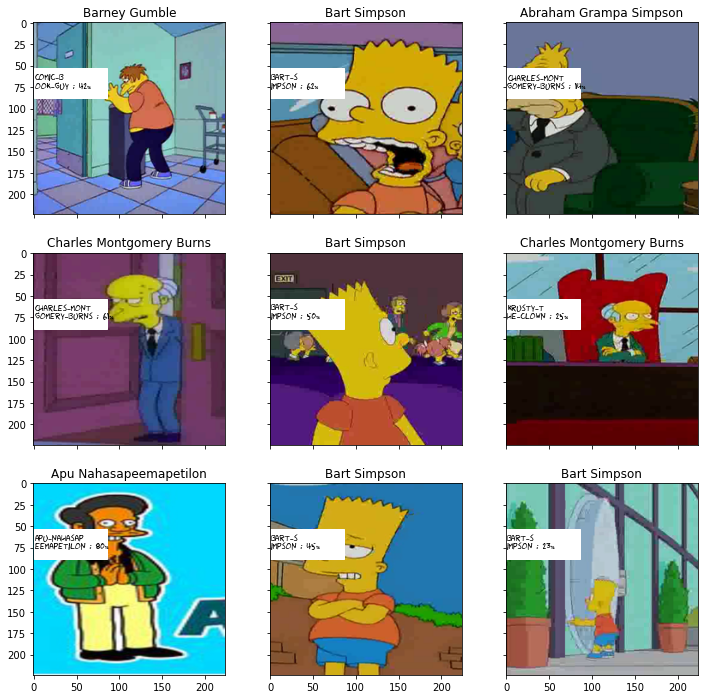

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [ ]:
for param in model.parameters():
    param.requires_grad = False

from itertools import chain

for param in chain(model.layer2.parameters(), model.layer3.parameters(), model.layer4.parameters(), model.fc.parameters()):
    param.requires_grad = True

optimizer  = torch.optim.AdamW(chain(model.layer2.parameters(), model.layer3.parameters(), model.layer4.parameters(), model.fc.parameters()), lr=4e-5)

In [ ]:
history = train(train_dataset, val_dataset, model,optimizer, epochs=3, batch_size=64)

epoch:   0%|          | 0/3 [00:07<?, ?it/s]


KeyboardInterrupt: ignored

In [ ]:
torch.save(model, './model_3layers')

In [ ]:
for param in model_1.parameters():
    param.requires_grad = False

from itertools import chain

for param in chain(model_1.layer3.parameters(), model_1.layer3.parameters(), model_1.layer4.parameters(), model_1.fc.parameters()):
    param.requires_grad = True

optimizer_1  = torch.optim.AdamW(chain(model_1.layer2.parameters(), model_1.layer3.parameters(), model_1.layer4.parameters(), model_1.fc.parameters()), lr=1e-4)


In [ ]:
###
for param in model_2.parameters():
    param.requires_grad = False


for param in chain(model_2.layer3.parameters(), model_2.layer4.parameters(), model_2.fc.parameters()):
    param.requires_grad = True

optimizer_2  = torch.optim.AdamW(chain(model_2.layer3.parameters(), model_2.layer4.parameters(), model_2.fc.parameters()), lr=5e-4)

In [ ]:
for param in model_3.parameters():
    param.requires_grad = False

for param in chain(model_3.layer4.parameters(), model_3.fc.parameters()):
    param.requires_grad = True

optimizer_3  = torch.optim.AdamW(chain(model_3.layer4.parameters(), model_3.fc.parameters()), lr=5e-4)

In [ ]:
history_1 = train(train_dataset, val_dataset, model_1, optimizer_1, epochs=3, batch_size=64)
torch.save(model_1, './model_1')

epoch:   0%|          | 0/3 [00:03<?, ?it/s]


KeyboardInterrupt: ignored

In [ ]:
torch.save(model_1, './model_1')

In [ ]:
history_2 = train(train_dataset, val_dataset, model_2, optimizer_2, epochs=2, batch_size=64)
torch.save(model, './model_2')

epoch:   0%|          | 0/2 [00:00<?, ?it/s]

loss 0.694390984764296


epoch:  50%|█████     | 1/2 [03:05<03:05, 185.52s/it]


Epoch 001 train_loss: 0.6944     val_loss 0.6946 train_acc 0.8198 val_acc 0.8120
loss 0.6943909369085889


epoch: 100%|██████████| 2/2 [06:11<00:00, 185.57s/it]


Epoch 002 train_loss: 0.6944     val_loss 0.6946 train_acc 0.8198 val_acc 0.8120


In [ ]:
history_3 = train(train_dataset, val_dataset, model_3, optimizer_3, epochs=2, batch_size=64)
torch.save(model, './model_3')

epoch:   0%|          | 0/2 [00:00<?, ?it/s]

loss 2.5866588639471892


epoch:  50%|█████     | 1/2 [03:14<03:14, 194.18s/it]


Epoch 001 train_loss: 2.5867     val_loss 1.4456 train_acc 0.3104 val_acc 0.6322


epoch:  50%|█████     | 1/2 [04:24<04:24, 264.69s/it]


KeyboardInterrupt: ignored

In [ ]:
print(history_)

[(0.6943909478146556, 0.8197974393273457, 0.694606642710329, tensor(0.8120, device='cuda:0', dtype=torch.float64)), (0.6943909333643545, 0.8197974393273457, 0.694606642710329, tensor(0.8120, device='cuda:0', dtype=torch.float64))]


In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model_1, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
import pandas as pd

In [ ]:
sample = pd.read_csv('/content/sample_submission.csv')
sample.head()

,Id,Expected
0,img0.jpg,bart_simpson
1,img1.jpg,bart_simpson
2,img2.jpg,bart_simpson
3,img3.jpg,bart_simpson
4,img4.jpg,bart_simpson


In [ ]:
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})

In [ ]:
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
my_submit.to_csv('./model.csv', index=False)

In [ ]:
from google.colab import files
files.download('./model_1')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model, ex_img.unsqueeze(0))
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model, imgs)
probs_ims_1 = predict(model_1, imgs)
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
y_pred = np.argmax(probs_ims,-1)
y_pred_1 = np.argmax(probs_ims_1,-1)
actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [ ]:
lis = []
for i in range(len(y_pred)):
  lis.append(y_pred[i])
lis

[2, 15, 2, 6, 6, 4, 3, 0, 4, 6, 0, 4, 6, 2, 22, 1, 6, 32, 3, 27]

In [ ]:
lis_1 = []
for i in range(len(y_pred_1)):
  lis_1.append(y_pred_1[i])
lis_1

[2, 4, 2, 6, 6, 4, 3, 0, 4, 6, 0, 4, 6, 2, 22, 1, 6, 4, 3, 4]

In [ ]:
print(actual_labels)
print(lis_1)
print(lis)

[2, 4, 2, 6, 6, 4, 3, 0, 4, 6, 0, 4, 6, 2, 4, 1, 6, 4, 3, 4]
[2, 4, 2, 6, 6, 4, 3, 0, 4, 6, 0, 4, 6, 2, 22, 1, 6, 4, 3, 4]
[2, 15, 2, 6, 6, 4, 3, 0, 4, 6, 0, 4, 6, 2, 22, 1, 6, 32, 3, 27]
